In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.model_selection import train_test_split,GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoLarsCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV, SelectFromModel
import pickle as pkl
import seaborn as sns
import xgboost as xgb
from scipy.stats import uniform, randint
import subprocess

In [16]:
def split_data(X_new):
    X_final, validate = np.split(X_new.sample(frac=1), [int(.8*len(X_new))])
    X_train, X_test, y_train, y_test = train_test_split(X_final.drop(columns=['pChemBL'],inplace=False), X_final['pChemBL'], test_size=0.2, random_state=42)
    X_validate = validate.drop(columns='pChemBL',inplace=False).copy()
    y_validate = validate['pChemBL']
    return X_train, X_test, X_validate, y_train, y_test, y_validate
def train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate,estimators=150):
    model2 = RandomForestRegressor(n_estimators=estimators)
    model2.fit(X_train,y_train)
    r_square = model2.score(X_train,y_train)
    rmse = np.sqrt(mean_squared_error(model2.predict(X_train),y_train))
    print('Number of estimators = {}'.format(estimators))
    print("Training set results:\nRMSE = {}\t R^2 = {}".format(rmse,r_square))
    q_square = model2.score(X_test,y_test)
    rmse = np.sqrt(mean_squared_error(model2.predict(X_test),y_test))
    print("Test set results\nRMSE = {}\t Q^2 = {}".format(rmse,q_square))
    q_square = model2.score(X_validate,y_validate)
    rmse = np.sqrt(mean_squared_error(y_validate,model2.predict(X_validate)))
    print("Validation set results\nRMSE = {}\t Q^2 = {}".format(rmse,q_square))    
    return model2
def split_train(X,estimators=150):
    X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X)
    model = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate,estimators)
    return model
def get_cols(n):
    cols = []
    for i in range(n):
        cols.append('component'+str(i+1))
    return cols
def scores(y_test,predictions):
    mse=mean_squared_error(predictions,y_test)
    y_mean = np.full(shape=y_test.shape,fill_value=y_test.mean())
    mse_ = mean_squared_error(y_mean,y_test)
    print("RMSE = ",np.sqrt(mse))
    print("Q^2 = ",1-(mse/mse_))

In [7]:
xg2 = pd.read_csv('xgd2.csv')
with open('./saved_models/xgreqd_cols.pkl','rb') as f:
    cols = pkl.load(f)
for col in cols:
    count = xg2[col].isna().sum()
    if count:
        print(col," ",count)

naAromAtom   1
nAromBond   1
BCUTc-1l   12
BCUTc-1h   12
BCUTp-1h   12
SpMin1_Bhm   6
SpMin2_Bhm   6
SpMin3_Bhm   6
SpMin4_Bhm   6
SpMax1_Bhv   6
SpMax2_Bhv   6
SpMin1_Bhv   6
SpMax1_Bhe   6
SpMax3_Bhe   6
SpMin1_Bhe   6
SpMin2_Bhe   6
SpMin4_Bhe   6
SpMin6_Bhe   6
SpMax1_Bhp   6
SpMax2_Bhp   6
SpMax3_Bhp   6
SpMin1_Bhp   6
SpMax1_Bhi   6
SpMin1_Bhi   6
SpMin2_Bhi   6
SCH-6   2737
VCH-5   2737
SpMAD_Dt   332
SHaaCH   10
SaaN   10
minHBa   10
maxaaN   10
hmin   10
MDEC-33   2
MDEN-22   2
MDEN-23   2
MLFER_A   1573
MLFER_BH   1573
piPC5   1
piPC7   1
piPC8   1
piPC9   1
piPC10   1
TpiPC   1
R_TpiPCTPC   1
nTRing   4
WTPT-4   796
WTPT-5   796


In [8]:
bad_cols = ['WTPT-4',"WTPT-5","SpMAD_Dt","MLFER_A","MLFER_BH","SCH-6","VCH-5"]

In [9]:
rfsk = pd.read_csv('./data/rfecvskb.csv')
rfsk.drop(columns=bad_cols,inplace=True)

In [12]:
reg = xgb.XGBRegressor()
reg.load_model('./saved_models/xg_final.model')

In [13]:
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(rfsk)

In [17]:
reg.fit(X_train,y_train)
predictions = reg.predict(X_test)
scores(y_test,predictions)

RMSE =  0.7264129551692743
Q^2 =  0.5841899518051463


In [18]:
predictions = reg.predict(X_validate)
scores(y_validate,predictions)

RMSE =  0.7120686989419284
Q^2 =  0.6195444768615059


<h1>38 descriptors

In [29]:
second_chance = rfsk.drop(columns=["SHaaCH","SaaN","minHBa","maxaaN","hmin"],inplace=False).copy()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(second_chance.drop(columns='pChemBL'),second_chance['pChemBL'],test_size=0.1,random_state=42)
reg = xgb.XGBRegressor(alpha=0.4, colsample_bytree=0.6, max_depth=7, min_child_weight=7,
             n_estimators=1000, seed=27, subsample=0.8,learning_rate=0.01)
param_test = {
 'max_depth':range(5,11,2),
 'min_child_weight':[5,7,9,11]
}
gsearch1 = GridSearchCV(estimator = reg,param_grid = param_test, scoring='neg_mean_squared_error',n_jobs=-1, cv=5,verbose=1)
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.6min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(alpha=0.4, colsample_bytree=0.6,
                                    learning_rate=0.01, max_depth=7,
                                    min_child_weight=7, n_estimators=1000,
                                    seed=27, subsample=0.8),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 11, 2),
                         'min_child_weight': [5, 7, 9, 11]},
             scoring='neg_mean_squared_error', verbose=1)

In [31]:
print(np.sqrt(0-gsearch1.best_score_))
best38 = gsearch1.best_estimator_
print(gsearch1.best_params_)
preds = best38.predict(X_test)
scores(y_test,preds)
best38.save_model('./saved_models/best_from_gs38.model')

0.6559508772995691
{'max_depth': 9, 'min_child_weight': 5}
RMSE =  0.5974416428566585
Q^2 =  0.7424214409982084


In [32]:
preds = best38.predict(X_train)
scores(y_train,preds)

RMSE =  0.22097044933258972
Q^2 =  0.9639602803066302


In [86]:
reg = xgb.XGBRegressor(alpha=0.4, colsample_bytree=0.6,
                                    learning_rate=0.01, max_depth=9,
                                    min_child_weight=5, n_estimators=1000,
                                    seed=27, subsample=0.8)
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(second_chance)
reg.fit(X_train,y_train)
predictions = reg.predict(X_test)
scores(y_test,predictions)
predictions = reg.predict(X_validate)
scores(y_validate,predictions)

RMSE =  0.636264995258674
Q^2 =  0.6873094497129433
RMSE =  0.6191679058652316
Q^2 =  0.749216606239191


In [87]:
reg.save_model('./saved_models/xg38.model')

<h1>43 descriptors

In [26]:
X_train, X_test, y_train, y_test = train_test_split(rfsk.drop(columns='pChemBL'),rfsk['pChemBL'],test_size=0.1,random_state=42)
reg = xgb.XGBRegressor(alpha=0.4, colsample_bytree=0.6, max_depth=7, min_child_weight=7,
             n_estimators=1000, seed=27, subsample=0.8,learning_rate=0.01)
param_test = {
 'max_depth':range(5,11,2),
 'min_child_weight':[5,7,9,11]
}
gsearch1 = GridSearchCV(estimator = reg, 
 param_grid = param_test, scoring='neg_mean_squared_error',n_jobs=-1, cv=5,verbose=1)
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.4min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(alpha=0.4, colsample_bytree=0.6,
                                    learning_rate=0.01, max_depth=7,
                                    min_child_weight=7, n_estimators=1000,
                                    seed=27, subsample=0.8),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 11, 2),
                         'min_child_weight': [5, 7, 9, 11]},
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
print(np.sqrt(0-gsearch1.best_score_))
best = gsearch1.best_estimator_
print(gsearch1.best_params_)
preds = best.predict(X_test)
scores(y_test,preds)
best.save_model('./saved_models/best_from_gs.model')

0.6491103160677638
{'max_depth': 9, 'min_child_weight': 7}
RMSE =  0.6107028774694965
Q^2 =  0.7308597442202267


In [24]:
best.save_model('./saved_models/best43.model')

In [25]:
reg = xgb.XGBRegressor(alpha=0.4, colsample_bytree=0.6,
                                    learning_rate=0.01, max_depth=9,
                                    min_child_weight=7, n_estimators=1000,
                                    seed=27, subsample=0.8)
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(rfsk)
reg.fit(X_train,y_train)
predictions = reg.predict(X_test)
scores(y_test,predictions)
predictions = reg.predict(X_validate)
scores(y_validate,predictions)

RMSE =  0.6555279773133559
Q^2 =  0.6747132687649459
RMSE =  0.6160835524226539
Q^2 =  0.7143639904362038


<h1>Verification

In [40]:
def get_padel(mol_folder_path,file_path,max_time='1500'):
    Padel_path = 'C:\\Users\\HP\\PaDEL-Descriptor\\PaDEL-Descriptor.jar'
    cmd_list = ['java','-jar',Padel_path, '-dir', mol_folder_path, '-2d','-file', file_path,'-maxruntime', max_time,"-descriptortypes", 'xg_desc3.xml','-usefilenameasmolname']
    out = subprocess.Popen(cmd_list, 
           stdout=subprocess.PIPE, 
           stderr=subprocess.STDOUT)
    stdout,stderr = out.communicate()
    stdout = stdout.decode('utf-8')
    with open('./Padel.txt','a') as f:
        f.write(stdout)
get_padel(r'C:\Users\HP\AZC_Internship\jupyter notebooks\mol','./xgdesc100.csv')

In [42]:
desc100 = pd.read_csv('./xgdesc100.csv')
bad = []
for col in desc100.columns:
    if col not in second_chance.columns:
        bad.append(col)
for col in second_chance.columns:
    if col not in desc100.columns:
        print(col)

pChemBL


In [43]:
desc100.drop(columns=bad,inplace=True)

In [74]:
desc100.isna().sum()

naAromAtom    0
nAromBond     0
BCUTc-1l      3
BCUTc-1h      3
BCUTp-1h      3
nBondsM       0
SpMin1_Bhm    1
SpMin2_Bhm    1
SpMin3_Bhm    1
SpMin4_Bhm    1
SpMax1_Bhv    1
SpMax2_Bhv    1
SpMin1_Bhv    1
SpMax1_Bhe    1
SpMax3_Bhe    1
SpMin1_Bhe    1
SpMin2_Bhe    1
SpMin4_Bhe    1
SpMin6_Bhe    1
SpMax1_Bhp    1
SpMax2_Bhp    1
SpMax3_Bhp    1
SpMin1_Bhp    1
SpMax1_Bhi    1
SpMin1_Bhi    1
SpMin2_Bhi    1
nAtomP        0
MDEC-33       1
MDEN-22       1
MDEN-23       1
piPC5         0
piPC7         0
piPC8         0
piPC9         0
piPC10        0
TpiPC         0
R_TpiPCTPC    0
nTRing        0
dtype: int64

<h2>Re-evaluating those molecules</h2> - 100,10 and 11

In [79]:
get_padel(r'C:\Users\HP\AZC_Internship\jupyter notebooks\unevalmol','./xgdesc3.csv','-1')
desc3 = pd.read_csv('./xgdesc3.csv')
bad = []
for col in desc3.columns:
    if col not in second_chance.columns:
        bad.append(col)
desc3.drop(columns=bad,inplace=True)
desc3.isna().sum()

naAromAtom    0
nAromBond     0
BCUTc-1l      0
BCUTc-1h      0
BCUTp-1h      0
nBondsM       0
SpMin1_Bhm    0
SpMin2_Bhm    0
SpMin3_Bhm    0
SpMin4_Bhm    0
SpMax1_Bhv    0
SpMax2_Bhv    0
SpMin1_Bhv    0
SpMax1_Bhe    0
SpMax3_Bhe    0
SpMin1_Bhe    0
SpMin2_Bhe    0
SpMin4_Bhe    0
SpMin6_Bhe    0
SpMax1_Bhp    0
SpMax2_Bhp    0
SpMax3_Bhp    0
SpMin1_Bhp    0
SpMax1_Bhi    0
SpMin1_Bhi    0
SpMin2_Bhi    0
nAtomP        0
MDEC-33       0
MDEN-22       0
MDEN-23       0
piPC5         0
piPC7         0
piPC8         0
piPC9         0
piPC10        0
TpiPC         0
R_TpiPCTPC    0
nTRing        0
dtype: int64

<b>Conclusion:</b>Upon re-evaluation, sometimes it gives NaN, other times it works perfectly.

<h1> Using the models on X_main

In [59]:
X_main = pd.read_csv('./no_zeros_no_chembl.csv')
y = X_main['pChemBL']
bad = []
for col in X_main.columns:
    if col not in second_chance.columns:
        bad.append(col)
X_main.drop(columns=bad,inplace=True)

In [60]:
X_main.drop(columns='pChemBL',inplace=True)

In [61]:
print(X_main.columns)

Index(['naAromAtom', 'nAromBond', 'BCUTc-1l', 'BCUTc-1h', 'BCUTp-1h',
       'nBondsM', 'SpMin1_Bhm', 'SpMin2_Bhm', 'SpMin3_Bhm', 'SpMin4_Bhm',
       'SpMax1_Bhv', 'SpMax2_Bhv', 'SpMin1_Bhv', 'SpMax1_Bhe', 'SpMax3_Bhe',
       'SpMin1_Bhe', 'SpMin2_Bhe', 'SpMin4_Bhe', 'SpMin6_Bhe', 'SpMax1_Bhp',
       'SpMax2_Bhp', 'SpMax3_Bhp', 'SpMin1_Bhp', 'SpMax1_Bhi', 'SpMin1_Bhi',
       'SpMin2_Bhi', 'nAtomP', 'MDEC-33', 'MDEN-22', 'MDEN-23', 'piPC5',
       'piPC7', 'piPC8', 'piPC9', 'piPC10', 'TpiPC', 'R_TpiPCTPC', 'nTRing'],
      dtype='object')


In [128]:
X_main.head()

,naAromAtom,nAromBond,BCUTc-1l,BCUTc-1h,BCUTp-1h,nBondsM,SpMin1_Bhm,SpMin2_Bhm,SpMin3_Bhm,SpMin4_Bhm,...,MDEN-22,MDEN-23,piPC5,piPC7,piPC8,piPC9,piPC10,TpiPC,R_TpiPCTPC,nTRing
0,16,18,-0.395197,0.211821,11.049269,18,2.082894,1.917433,1.844178,1.750754,...,1.190551,2.121320,6.437201,7.481230,7.991362,8.528420,8.939872,9.888853,11.822704,6
1,18,20,-0.324459,0.303911,11.858839,23,2.141224,2.023361,1.870068,1.784411,...,1.105209,1.190551,6.583841,7.714060,8.241999,8.756425,9.193246,10.122678,14.083920,9
2,27,29,-0.291902,0.416960,10.455854,30,2.049118,1.945557,1.911229,1.769681,...,2.576756,1.374730,6.481625,7.342774,7.783045,8.171347,8.584202,9.627425,11.948270,6
3,6,6,-0.386199,0.226178,11.054526,15,1.972555,1.908991,1.879489,1.851109,...,2.658167,0.927030,5.546397,5.544933,5.816739,5.858647,5.889570,7.770856,1.761710,2
4,21,23,-0.386171,0.198694,11.877160,25,2.019523,1.963038,1.877156,1.633266,...,0.000000,0.000000,6.608338,7.610075,8.146986,8.569907,8.994672,9.976050,14.000126,7


In [89]:
preds=best38.predict(X_main)
scores(y,preds)

RMSE =  0.28237514151854454
Q^2 =  0.9412880184367602


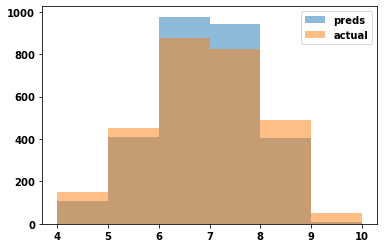

In [88]:
bins=np.linspace(4,10,7)
plt.hist(reg.predict(X_main),alpha=0.5,label='preds',bins=bins)
plt.hist(y,alpha=0.5,label='actual',bins=bins)
plt.legend(loc='upper right')
plt.show()

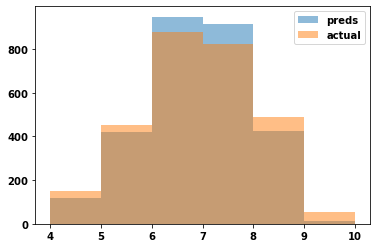

In [90]:
bins=np.linspace(4,10,7)
plt.hist(preds,alpha=0.5,label='preds',bins=bins)
plt.hist(y,alpha=0.5,label='actual',bins=bins)
plt.legend(loc='upper right')
plt.show()

<b> Both models perform well. In terms of statistics, best38 is better but by the looks of it, reg tends to predict the values outside the peak better

<h2>Scaling

In [80]:
scaling = StandardScaler()
scaling.fit(X_main)
da = scaling.transform(X_main)
X_scaled = pd.DataFrame(data=da,columns=X_main.columns)

In [84]:
X_scaled['pChemBL'] = y
reg_scaled = xgb.XGBRegressor(alpha=0.4, colsample_bytree=0.6,
                                    learning_rate=0.01, max_depth=9,
                                    min_child_weight=7, n_estimators=1000,
                                    seed=27, subsample=0.8)
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_scaled)
reg_scaled.fit(X_train,y_train)
predictions = reg_scaled.predict(X_test)
scores(y_test,predictions)
predictions = reg_scaled.predict(X_validate)
scores(y_validate,predictions)

RMSE =  0.6678130296505691
Q^2 =  0.6758148938639155
RMSE =  0.641277694458705
Q^2 =  0.690643713297785


I tried twice, scaling offers <b>no major improvement</b>

<b>Conclusion</b> Going to use best38(38 features without scaling)

<h1>Final padel verification

In [91]:
get_padel(r'C:\Users\HP\AZC_Internship\Data\molecular data\AKT_mol','./xgall.csv')
xg_all = pd.read_csv('./xgall.csv')
bad = []
print(len(xg_all.columns))
for col in xg_all.columns:
    if col not in second_chance.columns:
        bad.append(col)
xg_all.drop(columns=bad,inplace=True)
xg_all.isna().sum()

257


naAromAtom    0
nAromBond     0
BCUTc-1l      4
BCUTc-1h      4
BCUTp-1h      4
nBondsM       0
SpMin1_Bhm    5
SpMin2_Bhm    5
SpMin3_Bhm    5
SpMin4_Bhm    5
SpMax1_Bhv    5
SpMax2_Bhv    5
SpMin1_Bhv    5
SpMax1_Bhe    5
SpMax3_Bhe    5
SpMin1_Bhe    5
SpMin2_Bhe    5
SpMin4_Bhe    5
SpMin6_Bhe    5
SpMax1_Bhp    5
SpMax2_Bhp    5
SpMax3_Bhp    5
SpMin1_Bhp    5
SpMax1_Bhi    5
SpMin1_Bhi    5
SpMin2_Bhi    5
nAtomP        0
MDEC-33       0
MDEN-22       0
MDEN-23       0
piPC5         0
piPC7         0
piPC8         0
piPC9         0
piPC10        0
TpiPC         0
R_TpiPCTPC    0
nTRing        0
dtype: int64

In [99]:
xg_all[pd.isnull(xg_all).any(axis=1)]

,naAromAtom,nAromBond,BCUTc-1l,BCUTc-1h,BCUTp-1h,nBondsM,SpMin1_Bhm,SpMin2_Bhm,SpMin3_Bhm,SpMin4_Bhm,...,MDEN-22,MDEN-23,piPC5,piPC7,piPC8,piPC9,piPC10,TpiPC,R_TpiPCTPC,nTRing
254,0,0,-0.361008,0.227780,11.069613,13.0,NaN,NaN,NaN,NaN,...,2.658167,1.584761,5.541264,5.549076,5.789960,5.799093,5.786897,7.760041,1.630042,1.0
258,0,0,-0.361007,0.227721,11.070508,13.0,NaN,NaN,NaN,NaN,...,2.658167,1.584761,5.541264,5.556828,5.777652,5.783825,5.780744,7.754910,1.635344,1.0
259,0,0,-0.361010,0.227819,11.070312,13.0,NaN,NaN,NaN,NaN,...,2.658167,1.584761,5.549076,5.568345,5.796058,5.811141,5.799093,7.771067,1.622177,1.0
260,0,0,-0.361012,0.227868,11.070661,13.0,NaN,NaN,NaN,NaN,...,2.658167,1.584761,5.552960,5.583496,5.811141,5.817111,5.811141,7.780721,1.615800,1.0
265,0,0,-0.360993,0.272152,11.070794,14.0,NaN,NaN,NaN,NaN,...,3.991560,2.230292,5.587249,5.634790,5.874931,5.902633,5.899897,7.837949,1.598738,2.0
918,0,0,NaN,NaN,NaN,12.0,1.937836,1.911127,1.734987,1.689721,...,2.406843,3.256602,6.021023,6.783325,7.199678,7.529943,7.913887,9.041567,4.172925,9.0
1504,0,0,NaN,NaN,NaN,16.0,1.982088,1.918229,1.895995,1.854072,...,3.952490,2.524153,6.381816,7.126891,7.558517,7.974877,8.348301,9.429877,5.447944,15.0
1568,0,0,NaN,NaN,NaN,16.0,1.983144,1.933389,1.902282,1.870293,...,3.151584,2.163019,6.381816,7.126891,7.558517,7.974877,8.348301,9.429877,5.447944,15.0
1636,0,0,NaN,NaN,NaN,16.0,2.041661,1.926463,1.918223,1.848555,...,2.114371,1.654588,6.369901,7.105786,7.520235,7.980366,8.362409,9.426177,5.712707,14.0


In [100]:
files=['CHEMBL1800267','CHEMBL1800388','CHEMBL1800386','CHEMBL1800390','CHEMBL1800402','CHEMBL2386853','CHEMBL3684373','CHEMBL3684439','CHEMBL3684507']

In [104]:
mol= []
from rdkit import Chem
for file in files:
    m = Chem.MolFromMolFile('C:\\Users\\HP\\AZC_Internship\\Data\\molecular data\\AKT_mol\\'+str(file)+'.mol')
    mol.append(m)


In [108]:

i = 0
folder_path = './unevalmol/'
for m in mol:
    print(Chem.MolToMolBlock((m)),file=open(str(folder_path)+str(files[i])+'.mol','w'))
    i = i +1

In [109]:
get_padel(r'C:\Users\HP\AZC_Internship\jupyter notebooks\unevalmol','./uneval_desc.csv','-1')

In [112]:
unevalmol = pd.read_csv('./uneval_desc.csv')
bad = []
print(len(unevalmol.columns))
for col in unevalmol.columns:
    if col not in second_chance.columns:
        bad.append(col)
unevalmol.drop(columns=bad,inplace=True)
unevalmol.isna().sum(axis=1)

257


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

In [114]:
xg_all_all = pd.concat([xg_all,unevalmol])
xg_all_all.dropna(inplace=True)
len(xg_all_all)

2861

(array([149., 453., 876., 825., 490.,  53.]),
 array([ 4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 6 Patch objects>)

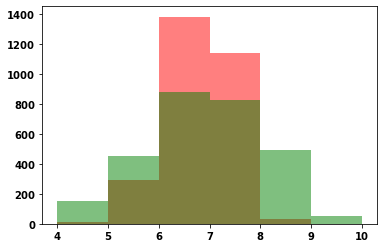

In [119]:
preds = reg.predict(xg_all_all)
bins=np.linspace(4,10,7)
plt.hist(preds,bins=bins,alpha=0.5,color='red')
plt.hist(y,bins=bins,alpha=0.5,color='green')

In [127]:
(second_chance.drop(columns='pChemBL',inplace=False).columns == xg_all_all.columns).all()

True

In [125]:
second_chance

SyntaxError: invalid syntax (<ipython-input-125-c1457ecd3f8d>, line 1)

In [130]:
(X_main == second_chance.drop(columns='pChemBL',inplace=False)).all()

naAromAtom    True
nAromBond     True
BCUTc-1l      True
BCUTc-1h      True
BCUTp-1h      True
nBondsM       True
SpMin1_Bhm    True
SpMin2_Bhm    True
SpMin3_Bhm    True
SpMin4_Bhm    True
SpMax1_Bhv    True
SpMax2_Bhv    True
SpMin1_Bhv    True
SpMax1_Bhe    True
SpMax3_Bhe    True
SpMin1_Bhe    True
SpMin2_Bhe    True
SpMin4_Bhe    True
SpMin6_Bhe    True
SpMax1_Bhp    True
SpMax2_Bhp    True
SpMax3_Bhp    True
SpMin1_Bhp    True
SpMax1_Bhi    True
SpMin1_Bhi    True
SpMin2_Bhi    True
nAtomP        True
MDEC-33       True
MDEN-22       True
MDEN-23       True
piPC5         True
piPC7         True
piPC8         True
piPC9         True
piPC10        True
TpiPC         True
R_TpiPCTPC    True
nTRing        True
dtype: bool

conclusion: Model is fine

In [134]:
cols = X_main.columns
len(cols)

38

In [137]:
with open('./saved_models/good_columns','wb') as f:
    pkl.dump(cols,f)

In [148]:
get_padel(r'.\mol','./descriptors.csv')

xg_all = pd.read_csv('./descriptors.csv')

names = xg_all['Name']

bad = []
with open('./saved_models/good_columns','rb') as f:
    cols = pkl.load(f)
for col in xg_all.columns:
    if col not in cols:
        bad.append(col)
xg_all.drop(columns=bad,inplace=True)

xg_all['Name'] = names

files = xg_all[pd.isnull(xg_all).any(axis=1)]['Name']
xg_all.dropna(inplace=True)
mol= []
for file in files:
    m = Chem.MolFromMolFile('C:\\Users\\HP\\AZC_Internship\\Data\\molecular data\\AKT_mol\\'+str(file)+'.mol')
    mol.append(m)

i = 0
folder_path = './unevalmol/'
for m in mol:
    print(Chem.MolToMolBlock((m)),file=open(str(folder_path)+str(files[i])+'.mol','w'))
    i = i +1
get_padel(r'C:\Users\HP\AZC_Internship\jupyter notebooks\unevalmol','./uneval_desc.csv','-1')
unevalmol = pd.read_csv('./uneval_desc.csv')


unevalmol.drop(columns=bad,inplace=True)
print(unevalmol.isna().sum(axis=1))

regressor = xgb.XGBRegressor()
regressor.load_model('./saved_models/best_from_gs38.model')


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64


(array([ 0.,  6., 66., 25.,  0.,  0.]),
 array([ 4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 6 Patch objects>)

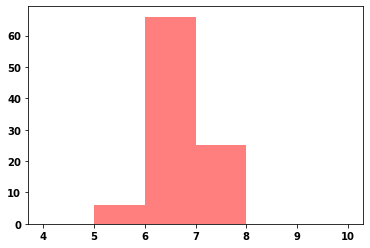

In [150]:
xg_all_all = pd.concat([xg_all,unevalmol])
xg_all_all.sort_values(by='Name',inplace=True)
xg_all_all.drop(columns='Name',inplace=True)
preds = reg.predict(xg_all_all)

bins=np.linspace(4,10,7)
plt.hist(preds,bins=bins,alpha=0.5,color='red')

In [152]:
len(unevalmol.columns)

38

<h1>Complete